# Data import

In [1]:
!pip install dateparser
!pip install workalendar

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateparser
import statsmodels.api as sm
import statsmodels.tsa as tsa
import keras
from keras.layers import Dense
from workalendar.europe import Hungary

In [3]:
# Prices
trees = [ET.parse(f'/content/drive/MyDrive/BME/2. félév/Önálló labor 2/Prices/{year}.xml').getroot() for year in range(2017,2024)]
values = np.array([float(time.text) for tree in trees for time in tree.iter('price.amount')])
values = values.reshape(len(values) // 24, 24)    # All times in CET - ignores DST
dates = np.array([np.datetime64(time[1].text[:10]) for tree in trees for time in tree.iter('timeInterval')])
data = pd.DataFrame(values).set_index(dates)
baseline = pd.DataFrame(values[:-7]).set_index(dates[7:])

In [4]:
stacked_data = pd.DataFrame(data.stack())
stacked_dates = pd.Index([t[0] + pd.Timedelta(hours=t[1]) for t in np.array(stacked_data.index)])
stacked_data = stacked_data.set_index(stacked_dates)
stacked_baseline = pd.DataFrame(baseline.stack())
stacked_baseline = stacked_baseline.set_index(stacked_dates[168:])

In [5]:
df = stacked_data.rename(columns={0: 'data'})
df['baseline'] = stacked_baseline

In [6]:
# BUX
bux = pd.ExcelFile('https://statisztika.mnb.hu/timeseries/Buxindex_hu.xls').parse(skiprows=4, index_col=0)
bux = bux.drop(index=bux.index[0])
bux['BUX'] = bux['BUX'].astype('float64')

In [7]:
# Deviza
deviza = pd.read_html('https://www.mnb.hu/arfolyam-tablazat?deviza=rbCustom&devizaSelected=EUR&datefrom=2017.12.22.&datetill=2023.10.31.&order=1&customdeviza%5B%5D=EUR&customdeviza%5B%5D=USD')[0]
deviza.columns = ['Dátum', 'EUR', 'USD']
deviza['Dátum'] = deviza['Dátum'].apply(dateparser.parse)
deviza = deviza.set_index('Dátum')

In [8]:
financial = bux.merge(deviza, how='inner', left_on=bux.index, right_on=deviza.index).set_index('key_0')
financial = financial.merge(pd.DataFrame(index=pd.date_range('2017-12-25', '2023-10-31')), how='outer', left_index=True, right_index=True).ffill().sort_index().iloc[1:]
financial = financial[~financial.index.duplicated(keep='first')]
financial.index = financial.index.shift(10, freq='H').tz_localize('UTC').tz_convert('Europe/Berlin')

In [7]:
# Weather
weather_hist = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/HABP_1H_20100407_20221231_44625.csv', skiprows=5, sep=';')
weather_rec = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/HABP_1H_20230101_20231124_44625.csv', skiprows=5, sep=';')
weather = pd.concat([weather_hist, weather_rec])

In [8]:
weather.columns = [col.strip() for col in weather.columns]
weather = weather.drop([col for col in weather.columns if col[:2] == 'Q_'], axis=1)
weather = weather.drop([col for col in weather.columns if (weather[col] == -999).all()], axis=1)
weather = weather.drop(['StationNumber', 'EOR', 'fxdat'], axis=1)
weather = weather.rename({'Time': 'mérési időpont', 'r': 'csapadékösszeg', 't': 'pillanatnyi hőmérséklet', 'ta': 'átlaghőmérséklet',
                          'tn': 'minimumhőmérséklet', 'tx': 'maximumhőmérséklet', 'p': 'műszerszinti légnyomás', 'u': 'relatív nedvesség',
                          'sr': 'globálsugárzás összeg', 'fs': 'szinoptikus szélsebesség', 'fsd': 'szinoptikus szélirány',
                          'fx': 'maximális széllökés sebessége', 'fxd': 'maximális széllökés iránya', 'p0': 'pillanatnyi tengerszinti légnyomás',
                          'f': 'átlagos szélsebesség', 'fd': 'szélirány', 'tsn': 'felszínközeli hőmérséklet minimuma'}, axis=1)
weather['mérési időpont'] = weather['mérési időpont'].apply(lambda x: str(x)).apply(lambda x: f'{x[:4]}-{x[4:6]}-{x[6:8]} {x[8:10]}:{x[10:12]}').astype('datetime64').apply(lambda x: x + pd.Timedelta(hours=1))
weather = weather.set_index('mérési időpont')

In [9]:
df = weather.merge(df, how='inner', left_on=weather.index, right_on=df.index).set_index('key_0')
df = df.dropna(subset=['data'])
df = df[~df.index.duplicated(keep='first')]

In [10]:
# Workdays
cal = Hungary()
workdays = pd.date_range('2017-12-25T00:00+01:00', '2023-10-31T00:00+01:00', freq='D').tz_convert('Europe/Berlin')
workdays = pd.Series(workdays.map(cal.is_working_day), index=workdays)

In [11]:
# Munkanap-áthelyezések
# 2017
# Nincs munkanap-áthelyezés

# 2018
workdays['2018-03-10'] = True
workdays['2018-03-16'] = False
workdays['2018-04-21'] = True
workdays['2018-04-30'] = False
workdays['2018-10-13'] = True
workdays['2018-10-22'] = False
workdays['2018-11-02'] = False
workdays['2018-11-10'] = True
workdays['2018-12-01'] = True
workdays['2018-12-15'] = True
workdays['2018-12-24'] = False
workdays['2018-12-31'] = False

# 2019
workdays['2019-08-10'] = True
workdays['2019-08-19'] = False
workdays['2019-12-07'] = True
workdays['2019-12-14'] = True
workdays['2019-12-24'] = False
workdays['2019-12-31'] = False

# 2020
workdays['2020-08-21'] = False
workdays['2020-08-29'] = True
workdays['2020-12-12'] = True
workdays['2020-12-24'] = False

# 2021
workdays['2021-12-11'] = True
workdays['2021-12-24'] = False

# 2022
workdays['2022-03-14'] = False
workdays['2022-03-26'] = True
workdays['2022-10-15'] = True
workdays['2022-10-31'] = False

# 2023
# Nincs munkanap-áthelyezés

In [12]:
workdays = workdays.astype('int64')

# Train and test data

In [13]:
df.index = df.index.shift(-1, freq='H').tz_localize('UTC').tz_convert('Europe/Berlin')

In [14]:
df['data'].to_csv('prices.csv')

In [15]:
dates_train = pd.date_range('2018-01-01T00:00+01:00', '2022-12-30T23:00+01:00', freq='H').tz_convert('Europe/Berlin')

In [16]:
dates_test = pd.date_range('2023-01-01T00:00+01:00', '2023-10-30T23:00+01:00', freq='H').tz_convert('Europe/Berlin')

In [ ]:
# Input: previous 168 hours of weather and price data, hour at the start of observations, workdays in the input and output period
X_train = pd.DataFrame([df.drop(['baseline'], axis=1).loc[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1)].unstack().to_numpy() for date in dates_train])    # weather and price data
X_train = pd.concat([X_train, pd.Series([date.hour for date in dates_train], name=X_train.columns.max()+1)], axis=1)  # starting hour
X_train = pd.concat([X_train, pd.DataFrame(np.array([workdays[date+pd.Timedelta(hours=-168):date+pd.Timedelta(hours=23)] for date in dates_train]))], axis=1)   # workdays
# X_train = pd.concat([X_train, pd.DataFrame(np.array([financial[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1)].unstack() for date in dates_train]))], axis=1)    # financial data
X_train.columns = np.arange(0, len(X_train.columns))
X_train.index = dates_train

In [17]:
# Input: previous 168 hours of weather and price data, hour at the start of observations, workdays in the input and output period
X_test = pd.DataFrame([df.drop(['baseline'], axis=1).loc[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1)].unstack().to_numpy() for date in dates_test])
X_test = pd.concat([X_test, pd.Series([date.hour for date in dates_test], name=X_test.columns.max()+1)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(np.array([workdays[date+pd.Timedelta(hours=-168):date+pd.Timedelta(hours=23)] for date in dates_test]))], axis=1)
# X_test = pd.concat([X_test, pd.DataFrame(np.array([financial[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1)].unstack() for date in dates_test]))], axis=1)
X_test.columns = np.arange(0, len(X_test.columns))
X_test.index = dates_test
y_test = pd.DataFrame(np.array([df.loc[date:date+pd.Timedelta(hours=23), 'data'].to_numpy() for date in dates_test]), columns=np.arange(0,24), index=dates_test)

In [ ]:
y_train = pd.DataFrame(np.array([df.loc[date:date+pd.Timedelta(hours=23), 'data'].to_numpy() for date in dates_train]), columns=np.arange(0,24), index=dates_train)

In [ ]:
X_train.to_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/X.csv')

In [ ]:
y_train.to_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/y.csv')

In [18]:
X_train = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/X.csv', index_col=0)

In [19]:
y_train = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/y.csv', index_col=0)

# Baseline

In [20]:
bl = df.loc[pd.to_datetime('2023-01-01T00:00+01:00'):, ['data', 'baseline']]

In [21]:
bl.corr().iloc[0,1]**2

0.45258828009977287

In [22]:
((bl['data'] - bl['baseline'])**2).mean()**0.5

38.54969573048312

# Decomposition

In [23]:
dc = tsa.seasonal.seasonal_decompose(df.loc[pd.to_datetime('2017-12-25T00:00+01:00'):pd.to_datetime('2022-12-31T23:00+01:00'), 'data'], two_sided=False, period=168)

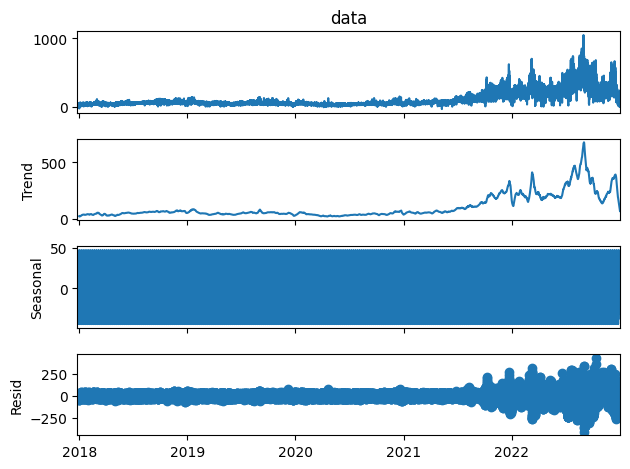

In [24]:
plot = dc.plot()

Text(0.5, 0, 'Seasonal component')

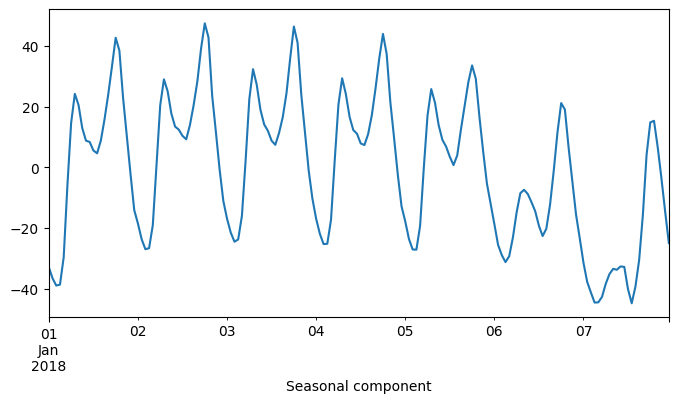

In [25]:
plt.figure(figsize=(8,4))
dc.seasonal.iloc[168:168*2].plot()
plt.xlabel('Seasonal component')

In [ ]:
model_resid = keras.models.Sequential()
model_resid.add(Dense(128, input_dim=2865, activation='relu'))
model_resid.add(Dense(64, activation='relu'))
model_resid.add(Dense(24, activation='linear'))
model_resid.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
checkpoint_resid = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_resid.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)

In [ ]:
y_resid = np.array([dc.resid[date:date+pd.Timedelta(hours=23)].to_numpy() for date in pd.date_range('2018-01-01T00:00+01:00', '2022-12-30T23:00+01:00', freq='H')])

In [ ]:
model_resid.fit(x=X_train, y=y_resid, batch_size=1000, epochs=100, validation_split=0.1, callbacks=[checkpoint_resid])

Epoch 1/100
39/40 [============================>.] - ETA: 0s - loss: 388.7209 - mae: 14.9414
Epoch 1: val_loss did not improve from 8408.91602
40/40 [==============================] - 3s 75ms/step - loss: 388.2895 - mae: 14.9365 - val_loss: 8433.9902 - val_mae: 68.8030
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 388.9944 - mae: 14.9512
Epoch 2: val_loss did not improve from 8408.91602
40/40 [==============================] - 3s 88ms/step - loss: 389.0307 - mae: 14.9525 - val_loss: 8451.9111 - val_mae: 68.7964
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 403.9039 - mae: 15.1693
Epoch 3: val_loss did not improve from 8408.91602
40/40 [==============================] - 4s 96ms/step - loss: 403.9039 - mae: 15.1693 - val_loss: 8506.1758 - val_mae: 68.9996
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 392.5463 - mae: 15.0105
Epoch 4: val_loss improved from 8408.91602 to 8322.33984, saving model to /content/drive/MyDrive/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 80ms/step - loss: 392.7391 - mae: 15.0137 - val_loss: 8322.3398 - val_mae: 68.2702
Epoch 5/100
39/40 [============================>.] - ETA: 0s - loss: 382.4891 - mae: 14.8663
Epoch 5: val_loss did not improve from 8322.33984
40/40 [==============================] - 2s 52ms/step - loss: 382.3741 - mae: 14.8665 - val_loss: 8447.3535 - val_mae: 68.9182
Epoch 6/100
40/40 [==============================] - ETA: 0s - loss: 378.6882 - mae: 14.8074
Epoch 6: val_loss did not improve from 8322.33984
40/40 [==============================] - 2s 51ms/step - loss: 378.6882 - mae: 14.8074 - val_loss: 8393.0576 - val_mae: 68.5803
Epoch 7/100
39/40 [============================>.] - ETA: 0s - loss: 378.7651 - mae: 14.8075
Epoch 7: val_loss did not improve from 8322.33984
40/40 [==============================] - 3s 69ms/step - loss: 378.6299 - mae: 14.8069 - val_loss: 8398.7549 - val_mae: 68.6775
Epoch 8/100
39/40 [============================>.] - ETA: 0s - 

In [ ]:
model_resid.save('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_resid.keras')

In [26]:
model_resid = keras.models.load_model('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_resid.keras')

In [27]:
def predict_decomposition(date):
    # Seasonal component
    date_seasonal = date
    while date_seasonal > pd.to_datetime('2022-12-30T23:00+01:00'):
        date_seasonal += pd.Timedelta(hours=-168)
    s = dc.seasonal[date_seasonal:date_seasonal+pd.Timedelta(hours=23)].to_numpy()

    # Trend component
    X = sm.add_constant(df.loc[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1), 'data'].reset_index())
    X['date'] = X['key_0'].astype('int64') // 1e9
    reg = sm.OLS(X['data'], X[['const', 'date']]).fit()
    t = reg.predict([[1, date.timestamp()+3600*i] for i in range(24)])

    # Residual component
    X_resid = pd.DataFrame([df.drop(['EUR', 'USD', 'BUX', 'baseline'], axis=1).loc[date+pd.Timedelta(hours=-168):date+pd.Timedelta(minutes=-1)].unstack().to_numpy()])
    X_resid = pd.concat([X_resid, pd.Series([date.hour], name=X_resid.columns.max()+1)], axis=1)
    X_resid = pd.concat([X_resid, pd.DataFrame(np.array([workdays[date+pd.Timedelta(hours=-168):date+pd.Timedelta(hours=23)]]))], axis=1)
    X_resid.columns = np.arange(0, len(X_resid.columns))
    X_resid.index = [date]
    r = model_resid.predict(X_resid, verbose=0)[0]
    return s,t,r

In [ ]:
y_seasonal = []
y_trend = []
y_resid = []
for date in dates_test:
    s,t,r = predict_decomposition(date)
    y_seasonal += [s]
    y_trend += [t]
    y_resid += [r]
    print(date)
y_seasonal = np.array(y_seasonal)
y_trend = np.array(y_trend)
y_resid = np.array(y_resid)

In [ ]:
pd.DataFrame(y_seasonal, index=dates_test).to_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_seasonal.csv')
pd.DataFrame(y_trend, index=dates_test).to_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_trend.csv')
pd.DataFrame(y_resid, index=dates_test).to_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_resid.csv')

In [29]:
y_seasonal = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_seasonal.csv', index_col=0)
y_trend = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_trend.csv', index_col=0)
y_resid = pd.read_csv('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/dc_pred_resid.csv', index_col=0)

In [30]:
y_seasonal.index = dates_test
y_trend.index = dates_test
y_resid.index = dates_test
y_seasonal.columns = y_seasonal.columns.astype('int64')
y_trend.columns = y_trend.columns.astype('int64')
y_resid.columns = y_resid.columns.astype('int64')

In [31]:
((y_seasonal + y_trend - y_test)**2).mean().mean()**0.5

38.15377150242165

In [35]:
y_test.unstack().corr((y_seasonal + y_trend).unstack())**2

0.3900318568524393

In [33]:
((y_seasonal + y_trend + y_resid - y_test)**2).mean().mean()**0.5

37.9863551389717

In [34]:
y_test.unstack().corr((y_seasonal + y_trend + y_resid).unstack())**2

0.39198772931848974

# Neural network

In [ ]:
model_nn = keras.models.Sequential()
model_nn.add(Dense(128, input_dim=len(X_train.columns), activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(24, activation='linear'))
model_nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)

In [ ]:
model_nn_history = pd.DataFrame(model_nn.fit(x=X_train, y=y_train, batch_size=1000, epochs=100, validation_split=0.1, callbacks=[checkpoint]).history)

Epoch 1/100
38/40 [===========================>..] - ETA: 0s - loss: 17762.8555 - mae: 81.9143
Epoch 1: val_loss improved from inf to 72527.10938, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 4s 56ms/step - loss: 17261.4355 - mae: 80.4267 - val_loss: 72527.1094 - val_mae: 221.1715
Epoch 2/100
37/40 [==========================>...] - ETA: 0s - loss: 2839.3206 - mae: 34.6933
Epoch 2: val_loss improved from 72527.10938 to 41523.45703, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn.hdf5
40/40 [==============================] - 1s 20ms/step - loss: 2797.0923 - mae: 34.4457 - val_loss: 41523.4570 - val_mae: 158.0032
Epoch 3/100
38/40 [===========================>..] - ETA: 0s - loss: 1883.6930 - mae: 28.5080
Epoch 3: val_loss improved from 41523.45703 to 19384.44531, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn.hdf5
40/40 [==============================] - 1s 19ms/step - loss: 1868.3456 - mae: 28.3954 - val_loss: 19384.4453 - val_mae: 104.9621
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 1383.7087 - mae: 24.7195
Epoch 4: val_loss improved from 19384

Text(0.5, 0, 'epoch')

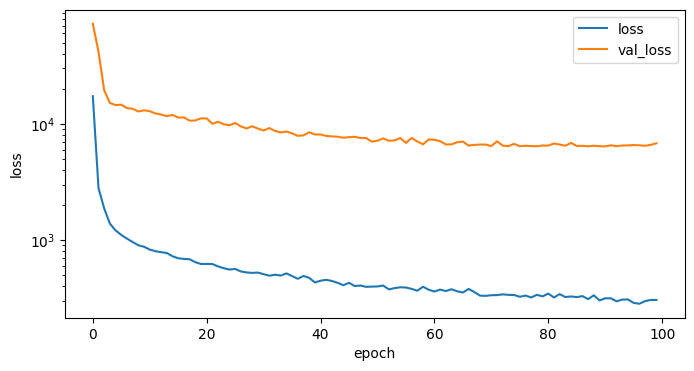

In [ ]:
model_nn_history[['loss', 'val_loss']].plot(figsize=(8,4))
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
model_nn.save('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_nn_final.keras')

In [36]:
model_nn = keras.models.load_model('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_nn_final.keras')

In [37]:
y_nn = model_nn.predict(X_test)

228/228 [==============================] - 4s 2ms/step


In [38]:
((y_nn - y_test)**2).mean().mean()**0.5

29.357366970728947

In [43]:
np.corrcoef(y_test.to_numpy().flatten(), y_nn.flatten())[0,1]**2

0.6155817512966006

Text(0, 0.5, 'y_pred')

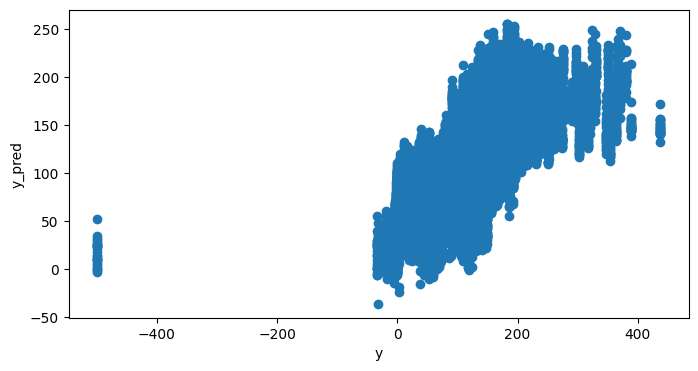

In [44]:
plt.figure(figsize=(8,4))
plt.scatter(y_test, y_nn)
plt.xlabel('y')
plt.ylabel('y_pred')

# Walk-forward

In [ ]:
model_wf = keras.models.Sequential()
model_wf.add(Dense(128, input_dim=len(X_train.columns), activation='relu'))
model_wf.add(Dense(64, activation='relu'))
model_wf.add(Dense(24, activation='linear'))
model_wf.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
checkpoint_wf = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_wf.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_frequency=1)

In [ ]:
model_wf_history = []
for p in range(5):
    model_wf_history += [pd.DataFrame(model_wf.fit(x=X_train.iloc[p*len(X_train)//8:(p+3)*len(X_train)//8],
                                                   y=y_train.iloc[p*len(y_train)//8:(p+3)*len(y_train)//8],
                                                   batch_size=1000,
                                                   epochs=20,
                                                   validation_data=(X_train.iloc[(p+3)*len(X_train)//8:(p+4)*len(X_train)//8], y_train.iloc[(p+3)*len(y_train)//8:(p+4)*len(y_train)//8]),
                                                   callbacks=[checkpoint_wf]).history)]

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 22802.3320 - mae: 97.5385 
Epoch 1: val_loss improved from inf to 1411.51794, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_wf.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 4s 81ms/step - loss: 22802.3320 - mae: 97.5385 - val_loss: 1411.5179 - val_mae: 30.7175
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 2249.1895 - mae: 39.5316
Epoch 2: val_loss improved from 1411.51794 to 1206.42139, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_wf.hdf5
17/17 [==============================] - 0s 25ms/step - loss: 2249.1895 - mae: 39.5316 - val_loss: 1206.4214 - val_mae: 27.8726
Epoch 3/20
16/17 [===========================>..] - ETA: 0s - loss: 1857.4265 - mae: 34.8306
Epoch 3: val_loss improved from 1206.42139 to 1076.82495, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_wf.hdf5
17/17 [==============================] - 0s 27ms/step - loss: 1853.2946 - mae: 34.7795 - val_loss: 1076.8250 - val_mae: 26.0908
Epoch 4/20
16/17 [===========================>..] - ETA: 0s - loss: 1414.3365 - mae: 29.7296
Epoch 4: val_loss improved from 1076.82495 t

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 1s 56ms/step - loss: 238.3296 - mae: 11.8838 - val_loss: 263.6755 - val_mae: 12.1676
Epoch 9/20
17/17 [==============================] - ETA: 0s - loss: 237.7424 - mae: 11.8689
Epoch 9: val_loss did not improve from 263.67554
17/17 [==============================] - 1s 42ms/step - loss: 237.7424 - mae: 11.8689 - val_loss: 268.3001 - val_mae: 12.4729
Epoch 10/20
16/17 [===========================>..] - ETA: 0s - loss: 235.9392 - mae: 11.8194
Epoch 10: val_loss did not improve from 263.67554
17/17 [==============================] - 1s 36ms/step - loss: 235.5276 - mae: 11.8113 - val_loss: 264.0213 - val_mae: 12.3478
Epoch 11/20
15/17 [=========================>....] - ETA: 0s - loss: 227.3909 - mae: 11.5946
Epoch 11: val_loss improved from 263.67554 to 255.20740, saving model to /content/drive/MyDrive/BME/2. félév/Önálló labor 2/best_nn_wf.hdf5
17/17 [==============================] - 1s 45ms/step - loss: 227.1659 - mae: 11.5876 - val_loss: 25

In [ ]:
model_wf.save('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_wf.keras')

In [45]:
model_wf = keras.models.load_model('/content/drive/MyDrive/BME/2. félév/Önálló labor 2/model_wf.keras')

In [ ]:
pd.concat(model_wf_history).reset_index()[['loss', 'val_loss']].plot(figsize=(8,4))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

[Text(-5000.0, 0, '-5000.0'),
 Text(0.0, 0, '0.0'),
 Text(5000.0, 0, '5000.0'),
 Text(10000.0, 0, '10000.0'),
 Text(15000.0, 0, '15000.0'),
 Text(20000.0, 0, '20000.0'),
 Text(25000.0, 0, '25000.0'),
 Text(30000.0, 0, '30000.0'),
 Text(35000.0, 0, '35000.0'),
 Text(40000.0, 0, '40000.0'),
 Text(45000.0, 0, '45000.0')]

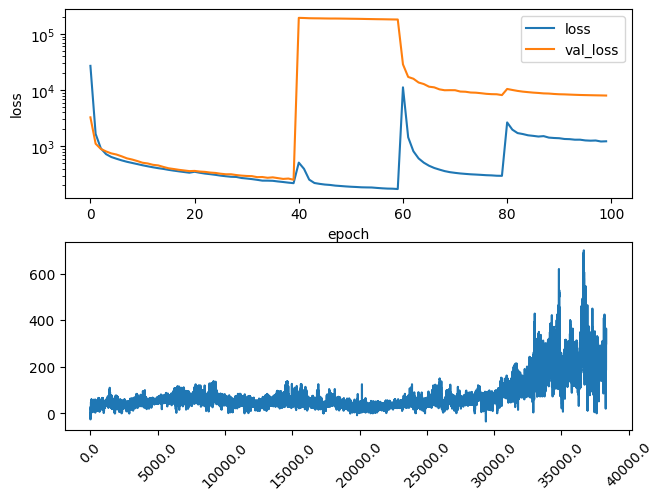

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout()
axes[0].set_yscale('log')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
pd.concat(model_wf_history).reset_index()[['loss', 'val_loss']].plot(ax=axes[0])
y_nn.plot(ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticks(), rotation=45)

In [47]:
y_wf = model_wf.predict(X_test)

228/228 [==============================] - 1s 2ms/step


In [48]:
((y_test - y_wf)**2).mean().mean()**0.5

40.796552426224615

In [50]:
np.corrcoef(y_test.to_numpy().flatten(), y_wf.flatten())[0,1]**2

0.26955447181750736

# Conclusion

<Axes: xlabel='hours since data', ylabel='root-mean-square error'>

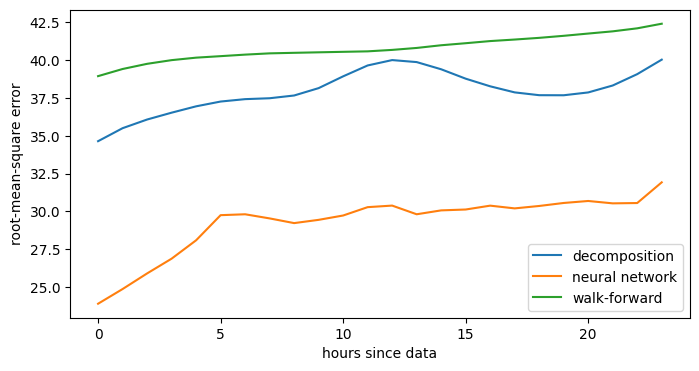

In [ ]:
pd.DataFrame([(((y_seasonal + y_trend + y_resid - y_test)**2).mean()**0.5), (((y_nn - y_test)**2).mean()**0.5), (((y_wf - y_test)**2).mean()**0.5)], index=['decomposition', 'neural network', 'walk-forward']).T.plot(figsize=(8,4), xlabel='hours since data', ylabel='root-mean-square error')

In [52]:
np.corrcoef(y_nn[:,0], y_test.iloc[:,0])[0,1]**2

0.7494863415967461

In [53]:
((y_nn[:,0] - y_test.iloc[:,0])**2).mean()**0.5

23.90234780345836